# Variational Autoencoder

In [59]:
import numpy as np


## generate random data

In [60]:
# matrixSize = 5

# A = np.random.rand(mean, matrixSize) * 2 
# B = np.dot(A, A.transpose())
# print(B)
# print(B.shape)

In [61]:
mean = np.array([20, 30, 50, 30, 40])
print(mean.shape)
# mean = [0, 0,0,0,0]
cov = [[1, 0,0,0,0], [0, 100,0,0,0],[0, 0,2,0,0],[0, 0,0,5,0],[0, 0,0,0,10]]  # diagonal covariance

# cov = B.copy()
# print(cov.shape)
dataset = np.random.multivariate_normal(mean, cov, 6000)
dataset = dataset.astype(np.float32)
print(dataset)
dim = dataset.shape[1]


(5,)
[[19.188128 35.96511  49.684887 28.664595 36.21845 ]
 [20.694677 27.724573 51.31375  30.7274   39.86705 ]
 [20.922144 32.619595 48.434937 29.184927 38.01664 ]
 ...
 [18.21121  34.97272  50.04489  32.319427 41.342163]
 [19.5347   39.934612 49.833668 26.509682 38.257416]
 [21.333605 28.652134 45.05466  30.974455 46.34103 ]]


## Model

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import datasets, transforms

In [63]:
class VAE(nn.Module):
    def __init__(self, zdim, input_dim):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(input_dim, 20)
        self.fc21 = nn.Linear(20, zdim) 
        self.fc22 = nn.Linear(20, zdim) 
        self.fc3 = nn.Linear(zdim, 20)
        self.fc4 = nn.Linear(20, input_dim)
        self.input_dim = input_dim
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn(mu.size(0),mu.size(1)) # assume eps normally distributed ~N(0,1)
#             eps = torch.randn_like(std)
            z = mu+ eps*std
#             return eps.mul(std).add_(mu)
            return z
#         else:
#             return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return self.fc4(h3)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [64]:
def bce_loss(y_pred, y_true, input_dim):
#     print(y_pred)
#     print(y_true.view(-1, input_dim))
    BCE = F.binary_cross_entropy(y_pred, y_true.view(-1, input_dim), reduction='sum')
    return BCE

def mse_loss(y_pred, y_true):
    loss = nn.MSELoss(reduction='sum', size_average=False)
    return loss(y_pred, y_true)

def kld_Loss(mu, logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return KLD

def loss_function(y_pred, y_true, input_dim):
    recon_x, mu, logvar = y_pred
    x = y_true


    KLD = kld_Loss(mu, logvar)

    MSE = mse_loss(recon_x, x)
    return KLD + MSE


In [65]:
def train(model, num_epochs = 1, batch_size = 64, learning_rate = 0.0002):
    model.train() #train mode
    torch.manual_seed(42)
    
    train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
    optimizer = optim.Adam(model.parameters(), learning_rate)
    
    for epoch in range(num_epochs):
      for data in train_loader:  # load batch
#           print(data)
          
          reconmulogvar = model(data)
          loss = loss_function(reconmulogvar, data, 5) # calculate loss
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
      
      print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))

In [66]:
batch_size = 256

model = VAE(5, 5)
train(model, num_epochs = 1000, batch_size = batch_size, learning_rate = 0.01)

/Users/yukuai/opt/anaconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch:1, Loss:186447.0000
Epoch:2, Loss:74330.5000
Epoch:3, Loss:48487.0039
Epoch:4, Loss:37506.1055
Epoch:5, Loss:31369.2305
Epoch:6, Loss:25792.8750
Epoch:7, Loss:23916.1133
Epoch:8, Loss:21519.0879
Epoch:9, Loss:20187.3984
Epoch:10, Loss:18341.3574
Epoch:11, Loss:15524.5684
Epoch:12, Loss:14126.4180
Epoch:13, Loss:12444.5723
Epoch:14, Loss:10902.7422
Epoch:15, Loss:9847.0518
Epoch:16, Loss:9274.9619
Epoch:17, Loss:9454.8145
Epoch:18, Loss:8364.1914
Epoch:19, Loss:8241.3662
Epoch:20, Loss:7782.4204
Epoch:21, Loss:7313.8833
Epoch:22, Loss:7437.4326
Epoch:23, Loss:7063.9321
Epoch:24, Loss:7479.5757
Epoch:25, Loss:6731.7734
Epoch:26, Loss:6925.3203
Epoch:27, Loss:6104.9512
Epoch:28, Loss:5940.8911
Epoch:29, Loss:5733.8594
Epoch:30, Loss:5722.2129
Epoch:31, Loss:5643.3140
Epoch:32, Loss:5467.8271
Epoch:33, Loss:5100.2422
Epoch:34, Loss:4852.6582
Epoch:35, Loss:4768.0547
Epoch:36, Loss:5404.8535
Epoch:37, Loss:4858.4082
Epoch:38, Loss:4924.1934
Epoch:39, Loss:4876.0601
Epoch:40, Loss:4853

Epoch:322, Loss:1618.3423
Epoch:323, Loss:1662.5405
Epoch:324, Loss:1603.2612
Epoch:325, Loss:1750.9734
Epoch:326, Loss:1773.2085
Epoch:327, Loss:1666.5305
Epoch:328, Loss:1916.5256
Epoch:329, Loss:1936.8806
Epoch:330, Loss:1549.6869
Epoch:331, Loss:1604.6212
Epoch:332, Loss:1614.2915
Epoch:333, Loss:1652.5049
Epoch:334, Loss:1583.5901
Epoch:335, Loss:1602.6531
Epoch:336, Loss:1497.5769
Epoch:337, Loss:1508.5228
Epoch:338, Loss:1565.5892
Epoch:339, Loss:1573.4205
Epoch:340, Loss:1687.3093
Epoch:341, Loss:1532.9514
Epoch:342, Loss:1813.4012
Epoch:343, Loss:1721.8571
Epoch:344, Loss:1694.9238
Epoch:345, Loss:1601.6836
Epoch:346, Loss:1566.8756
Epoch:347, Loss:1583.6051
Epoch:348, Loss:1564.8324
Epoch:349, Loss:1671.1729
Epoch:350, Loss:1560.3580
Epoch:351, Loss:1449.5909
Epoch:352, Loss:1543.9630
Epoch:353, Loss:1452.2567
Epoch:354, Loss:1525.5295
Epoch:355, Loss:1472.8481
Epoch:356, Loss:1481.6498
Epoch:357, Loss:1543.6006
Epoch:358, Loss:1549.7924
Epoch:359, Loss:1523.7075
Epoch:360, L

Epoch:640, Loss:1260.6560
Epoch:641, Loss:1296.1826
Epoch:642, Loss:1215.9132
Epoch:643, Loss:1149.2509
Epoch:644, Loss:1205.8816
Epoch:645, Loss:1220.8723
Epoch:646, Loss:1201.1226
Epoch:647, Loss:1195.5354
Epoch:648, Loss:1180.5131
Epoch:649, Loss:1264.8735
Epoch:650, Loss:1287.1091
Epoch:651, Loss:1161.9041
Epoch:652, Loss:1221.6190
Epoch:653, Loss:1132.3052
Epoch:654, Loss:1287.5571
Epoch:655, Loss:1169.8710
Epoch:656, Loss:1167.7136
Epoch:657, Loss:1153.7991
Epoch:658, Loss:1167.7490
Epoch:659, Loss:1179.6340
Epoch:660, Loss:1291.9666
Epoch:661, Loss:1171.6235
Epoch:662, Loss:1135.8232
Epoch:663, Loss:1236.6316
Epoch:664, Loss:1232.1019
Epoch:665, Loss:1204.4614
Epoch:666, Loss:1185.6420
Epoch:667, Loss:1267.2463
Epoch:668, Loss:1167.0386
Epoch:669, Loss:1181.8615
Epoch:670, Loss:1146.7922
Epoch:671, Loss:1161.2122
Epoch:672, Loss:1218.5508
Epoch:673, Loss:1071.3014
Epoch:674, Loss:1217.4141
Epoch:675, Loss:1207.3722
Epoch:676, Loss:1099.6552
Epoch:677, Loss:1238.8232
Epoch:678, L

Epoch:960, Loss:1102.0402
Epoch:961, Loss:1011.8259
Epoch:962, Loss:1092.4658
Epoch:963, Loss:1047.0725
Epoch:964, Loss:1075.3207
Epoch:965, Loss:1123.4854
Epoch:966, Loss:1038.2240
Epoch:967, Loss:1102.9249
Epoch:968, Loss:1200.3916
Epoch:969, Loss:1138.8499
Epoch:970, Loss:1089.7739
Epoch:971, Loss:1146.3334
Epoch:972, Loss:1032.3605
Epoch:973, Loss:1081.0933
Epoch:974, Loss:1111.0542
Epoch:975, Loss:1126.5419
Epoch:976, Loss:1095.2208
Epoch:977, Loss:1147.8394
Epoch:978, Loss:1094.5815
Epoch:979, Loss:1039.1293
Epoch:980, Loss:1116.1143
Epoch:981, Loss:1069.9513
Epoch:982, Loss:1118.4495
Epoch:983, Loss:1118.2332
Epoch:984, Loss:1159.5569
Epoch:985, Loss:1219.4987
Epoch:986, Loss:1172.7085
Epoch:987, Loss:1095.1549
Epoch:988, Loss:1116.6334
Epoch:989, Loss:1130.5873
Epoch:990, Loss:1071.1523
Epoch:991, Loss:1024.5127
Epoch:992, Loss:1086.4944
Epoch:993, Loss:1170.8806
Epoch:994, Loss:1170.6843
Epoch:995, Loss:1067.5350
Epoch:996, Loss:1075.1594
Epoch:997, Loss:1070.3262
Epoch:998, L

In [67]:
result = []
for i in range(1000):
  rinpt = torch.randn(1, 5)
  with torch.no_grad():
    si = model.decode(rinpt).numpy()
  result.append(si)

In [68]:

def get_most_similar_besides_i(simulated_data, test):
    min_idx = 100000
    min_distance = 1000000
    point2 = test
    for idx in range(len(simulated_data)):
        si = simulated_data[idx][0]
        distance = np.linalg.norm(si[:4] - point2[:4])
    #     print(distance)
        if distance < min_distance:
#             print(distance)
            min_idx = idx
            min_distance = distance
    return min_idx

In [69]:
result[504][0]

array([19.76823 , 35.197464, 49.3971  , 30.696167, 42.044186],
      dtype=float32)

In [70]:
dataset[0,:]

array([19.188128, 35.96511 , 49.684887, 28.664595, 36.21845 ],
      dtype=float32)

In [71]:
testing_dataset = np.random.multivariate_normal(mean, cov, 3000)
testing_dataset = testing_dataset.astype(np.float32)

In [72]:
testing_dataset

array([[20.23022 , 44.16203 , 49.438812, 33.009785, 33.275234],
       [18.787365, 25.26294 , 53.078293, 27.676678, 46.363396],
       [21.6555  , 37.913857, 50.713642, 31.350426, 38.122036],
       ...,
       [19.611158, 39.857147, 48.83303 , 31.271566, 38.500526],
       [21.072004, 37.129086, 48.74629 , 26.43252 , 35.083702],
       [19.159405, 37.55704 , 49.403606, 28.978697, 36.044178]],
      dtype=float32)

In [73]:
mean = np.array([20, 30, 50, 30, 40])

In [74]:
get_most_similar_besides_i(result, testing_dataset[1])

326

In [75]:
for i in range(testing_dataset.shape[0]):
    idx = get_most_similar_besides_i(result, testing_dataset[i])
    print(testing_dataset[i], end="\t")
    print(result[idx])

[20.23022  44.16203  49.438812 33.009785 33.275234]	[[20.251053 43.816483 49.89949  32.276688 37.02078 ]]
[18.787365 25.26294  53.078293 27.676678 46.363396]	[[19.452723 24.925951 51.42625  28.613209 36.37554 ]]
[21.6555   37.913857 50.713642 31.350426 38.122036]	[[19.990292 38.589447 50.82546  30.656382 37.83565 ]]
[19.75233  21.532265 49.224743 26.005342 37.15313 ]	[[20.161263 21.404444 49.143703 26.536106 42.241486]]
[20.368431 35.039673 49.679424 29.731937 36.011024]	[[20.281553 35.1903   49.940304 29.558716 33.289967]]
[20.129168 39.875664 50.628925 28.741375 44.970524]	[[19.917746 39.66241  50.99832  29.208769 38.352512]]
[20.532314 36.06972  50.822803 30.629356 37.707554]	[[20.076715 35.77402  50.651237 30.061844 43.177486]]
[21.106855 31.138752 49.49138  27.840536 41.416103]	[[20.355688 30.80952  49.6145   28.475378 38.554092]]
[18.35201  37.551064 51.585907 29.967665 43.389473]	[[18.9513   37.05696  51.407158 29.767954 44.536526]]
[20.163662 48.739002 50.607582 33.19922  34.91

[18.670753 38.73296  51.71543  29.606758 38.89009 ]	[[18.477802 39.167152 51.64163  29.579836 39.81098 ]]
[20.158781 37.560127 50.81235  33.102646 38.38377 ]	[[19.593603 36.596836 50.60435  32.76408  44.525127]]
[21.437664 39.136692 51.0397   29.317183 34.225548]	[[20.241762 38.97358  50.3876   29.835169 42.321297]]
[20.461456 23.548328 50.29248  29.652287 42.091244]	[[20.374378 23.516031 50.583317 29.91733  40.08863 ]]
[19.203045 33.122353 49.5896   28.753588 39.741993]	[[19.82665  33.488197 49.922714 29.027933 40.46406 ]]
[22.00348  32.098568 50.302593 31.658215 41.019283]	[[20.30152  31.440226 50.224026 31.581505 42.52198 ]]
[17.9489   35.45494  51.53268  29.692104 38.038372]	[[19.174988 35.59241  50.789524 30.241295 40.80702 ]]
[20.011362 34.893517 52.822464 27.493568 42.69173 ]	[[19.826727 34.777084 51.106243 27.892294 37.635696]]
[19.434519 18.65797  48.17286  24.975025 37.19649 ]	[[21.188894 20.030954 49.503532 25.702251 36.51856 ]]
[18.210707 28.217512 49.633423 30.030458 38.44

[18.67798  19.16224  50.309853 32.13691  36.677727]	[[19.66928  18.823652 50.95273  31.626139 36.742275]]
[19.682428 37.807644 49.794514 24.843899 36.75644 ]	[[19.697258 38.807095 50.640156 24.638083 38.064518]]
[20.613455 40.759563 50.441822 28.93694  39.957176]	[[20.469378 40.9856   50.77468  29.087366 38.430504]]
[20.937712 34.977783 50.867058 32.755463 44.363586]	[[20.115654 34.44828  49.82883  32.29657  39.70945 ]]
[20.691942 49.98738  50.04665  30.642864 36.462196]	[[20.597265 49.120083 49.31186  30.295013 36.927505]]
[19.510784 35.21145  50.692657 32.368294 36.872437]	[[18.949072 35.767643 50.83235  32.482204 40.844795]]
[20.276329 28.166868 49.789562 26.902172 43.446083]	[[19.780025 28.347025 49.544567 27.443295 43.46448 ]]
[20.468863 31.07983  48.70505  26.94586  39.515015]	[[21.023079 31.22788  48.689053 26.742441 41.0205  ]]
[19.436647 25.716677 48.24475  32.01943  39.53543 ]	[[19.611898 25.614365 49.284958 31.257666 41.93794 ]]
[18.323965 27.287823 48.41962  27.727531 39.65

[21.256847 54.66742  49.11579  28.886936 36.637997]	[[20.541288 54.997787 49.789448 29.283705 38.522194]]
[20.542398 19.054428 51.611946 28.210285 35.436134]	[[20.117842 19.13012  51.156853 27.105556 39.740295]]
[19.990568 44.505398 50.590355 29.670967 40.25902 ]	[[19.312206 43.987064 50.943478 29.504297 46.50272 ]]
[19.693182 31.590305 46.427315 34.58632  37.377895]	[[19.467268 31.101393 48.237686 33.852615 43.192818]]
[19.175133 36.125324 48.517788 34.301197 37.502266]	[[19.892618 35.929024 49.18142  33.823    34.55082 ]]
[19.730476 27.784275 50.742218 28.04708  43.39967 ]	[[19.615007 27.691025 51.191418 28.096472 39.854942]]
[21.445473 28.60331  46.44001  30.339554 40.418556]	[[21.092117 27.974737 47.77347  29.578735 46.574745]]
[20.783058 25.729393 50.833523 29.560787 39.215176]	[[19.987703 25.903734 50.7687   29.765913 35.446312]]
[20.939034 16.890837 51.433857 25.840326 35.605366]	[[20.581234 17.268616 51.129726 26.862087 34.567066]]
[20.395214 25.402418 49.88733  30.389935 40.15

[18.998356 37.134876 46.996063 27.310871 41.718998]	[[20.32161  36.078346 48.079075 27.385492 43.3441  ]]
[21.333738 20.577827 48.281517 28.729937 35.3711  ]	[[21.50144  21.118874 48.52243  29.117329 36.65135 ]]
[20.251682 34.621166 51.23675  33.393837 43.14169 ]	[[19.104511 35.21204  50.693817 33.477192 41.975212]]
[19.09318  36.308197 48.190186 32.06949  38.02549 ]	[[19.39615  36.382183 48.825596 31.196247 43.85431 ]]
[19.258476 26.897984 51.00561  31.473375 48.173702]	[[19.165995 26.854446 50.784737 31.0348   37.932354]]
[20.417992 42.527214 50.710335 31.832983 36.829453]	[[20.300467 42.269844 49.652653 32.57378  38.048386]]
[20.231524 38.13364  51.834156 28.67593  39.152264]	[[19.602207 38.099796 51.558674 28.431084 33.49652 ]]
[20.329815 48.263966 47.515713 31.190739 38.982536]	[[20.557846 48.51498  48.17689  31.691467 44.127834]]
[20.333448 29.646832 52.56957  29.06471  40.11867 ]	[[19.456963 29.45648  51.47034  28.599047 41.96439 ]]
[20.407087 24.16269  51.032475 29.535643 43.26

[20.621769  2.324895 47.03696  29.051105 42.441425]	[[20.079954   2.0551438 49.91377   30.610516  39.060616 ]]
[21.158312  9.561689 50.8532   32.5948   39.862648]	[[19.51887  10.44384  50.85274  32.454826 39.10926 ]]
[20.317673 48.58992  49.3331   29.188871 41.601673]	[[20.597265 49.120083 49.31186  30.295013 36.927505]]
[19.87505  28.913988 51.179497 27.227694 35.559746]	[[19.941656 29.682074 51.190224 26.954767 32.17688 ]]
[18.241322 25.550465 50.079872 28.806242 41.778564]	[[19.43302  25.329388 49.714745 29.589626 44.94971 ]]
[20.783165 22.827877 51.082085 33.51478  39.340687]	[[19.602087 22.770113 50.350357 32.658516 35.019184]]
[20.140734 26.71026  51.24678  31.668018 38.27589 ]	[[19.959677 26.301807 50.752804 31.254784 37.80798 ]]
[19.427658 36.88875  52.236763 31.340118 39.0166  ]	[[18.84001  36.9332   51.726513 31.14128  34.353603]]
[18.729969 31.497944 51.19072  27.928331 44.21518 ]	[[19.356045 31.275427 51.560818 27.805445 40.785805]]
[19.230911 30.834423 51.012684 29.15917  

[19.567999 50.647877 49.85467  33.73974  37.30504 ]	[[19.323801 52.005257 50.317135 32.621532 44.585205]]
[20.125004 35.016834 50.237503 34.286243 38.456917]	[[19.59962  34.50251  50.06928  35.112534 36.395218]]
[19.34366   9.159615 49.73073  29.240273 40.91366 ]	[[19.935106 10.004406 50.266582 29.39205  37.79918 ]]
[20.901917 27.752647 48.61821  27.03266  40.45315 ]	[[20.939772 28.031828 49.40409  27.200462 39.163826]]
[20.921648 24.961033 49.841724 31.461664 48.518703]	[[20.172657 25.617117 49.56318  31.226425 37.0813  ]]
[20.432577 34.87157  50.492325 29.324398 41.168514]	[[20.081415 35.2346   50.1309   29.38924  35.023865]]
[20.71429  31.567314 52.22201  32.099457 40.352356]	[[19.600676 32.504303 51.209244 31.455431 36.281544]]
[21.726198 25.54885  50.86557  27.763775 36.428455]	[[21.08186  25.345911 50.36471  27.344305 36.017735]]
[20.808071 39.472553 51.21988  29.984154 39.944553]	[[20.085634 39.280804 50.487995 30.09891  40.54143 ]]
[19.02084  41.536125 48.662548 28.001802 42.02

[20.903555 38.089886 51.392414 27.05136  47.86675 ]	[[20.319519 37.80343  50.243298 26.97681  38.949795]]
[17.802608 20.313509 51.03107  28.70178  44.97169 ]	[[19.233456 19.766487 50.434948 29.358562 44.16057 ]]
[17.697079 30.307787 50.146816 27.140854 37.46919 ]	[[19.724522 30.895485 49.72732  27.568966 44.561794]]
[19.577976 27.875637 49.799572 27.939142 37.487083]	[[19.905607 27.766285 50.31512  28.191713 40.407036]]
[20.75386  29.807312 51.01673  26.227093 40.059715]	[[20.432364 30.44683  50.810436 26.259636 37.88574 ]]
[20.543173 42.07641  50.13457  27.359465 42.54016 ]	[[20.43624  42.36058  50.061733 27.200262 39.720493]]
[20.752613 32.08072  50.45107  30.056845 41.57722 ]	[[20.436186 32.36411  50.299965 29.301928 37.55718 ]]
[21.124765 22.60526  50.23005  31.190706 39.11459 ]	[[20.74179  22.802034 49.93854  30.692123 35.286118]]
[20.438948 32.332554 49.09112  25.446547 42.8558  ]	[[21.156656 31.933844 48.406948 26.44407  37.96049 ]]
[19.659601 33.884117 50.35608  29.875717 41.00

[20.415045 34.122494 49.89859  29.22451  35.90332 ]	[[20.28926  33.994225 49.600716 28.748854 38.47535 ]]
[19.135956 19.728802 49.286987 27.18366  37.428814]	[[20.184324 20.445484 49.383144 27.464172 41.537277]]
[19.986542 26.68967  48.183018 29.47276  38.572563]	[[20.268906 26.595478 49.00917  30.18977  42.501125]]
[20.52172  28.267729 51.50031  27.598635 43.938576]	[[20.324902 28.125736 51.02459  27.777508 35.7788  ]]
[18.906479 30.287918 48.70572  33.46325  43.261375]	[[19.24429  31.092836 48.868286 33.37129  45.543064]]
[20.525393 19.988348 52.34352  27.66741  37.458157]	[[20.117842 19.13012  51.156853 27.105556 39.740295]]
[20.772585 42.719685 52.31431  31.589975 42.863083]	[[18.682405 41.40829  52.021576 31.172882 35.488842]]
[19.822092 31.08004  49.07062  31.31307  36.901848]	[[19.812386 31.384897 49.308155 31.697487 41.098534]]
[20.173124 32.70401  48.26976  27.847439 42.36045 ]	[[20.181114 32.576145 48.718456 28.39056  40.642292]]
[20.917524 33.243988 52.25082  30.798332 41.48

[18.80767  24.35191  51.2974   29.22851  43.214245]	[[18.40365  23.964293 52.083366 29.310156 44.2404  ]]
[19.844004 48.74541  52.309372 33.095585 44.985752]	[[19.685493 48.590923 50.18534  33.631207 40.492878]]
[21.972479 33.59949  50.39719  30.521355 39.708107]	[[20.14963  32.82879  50.794724 30.808378 35.00106 ]]
[21.050682 28.98941  49.952557 29.979033 37.87881 ]	[[20.627977 28.874123 49.89606  30.262526 39.009075]]
[21.273539 44.436634 50.123398 29.692072 38.039864]	[[20.362196 45.286953 50.008595 29.894108 39.267773]]
[19.741985 29.773699 47.931885 30.65527  40.60339 ]	[[20.484835 30.508162 48.44739  30.9529   43.28815 ]]
[20.9949   33.337215 48.744568 27.872824 39.3606  ]	[[21.346582 33.58354  48.35246  28.259243 42.675285]]
[19.469334 25.704285 52.166668 31.388657 43.537773]	[[19.164268 25.643797 51.46684  30.738714 38.326332]]
[18.621572 25.209776 51.09412  27.15642  36.626495]	[[19.171358 25.991434 50.611237 27.382275 41.03559 ]]
[19.773685 49.26989  48.168625 30.421665 39.25

[21.493551 33.179535 52.53772  29.114338 37.80802 ]	[[19.594568 32.428368 51.657276 29.147102 37.04394 ]]
[20.50522  27.188557 51.289097 28.648645 33.956917]	[[20.08676  27.516201 50.507484 28.597942 43.107025]]
[18.31872  22.121454 50.576862 28.864363 36.25278 ]	[[19.684462 22.19085  50.178825 29.304134 40.904552]]
[18.460583 27.89545  50.5777   29.459694 40.886177]	[[19.21656  28.444397 50.964233 29.863214 39.7721  ]]
[21.48165  41.72326  49.003677 30.200533 41.568264]	[[20.124159 42.41126  48.366566 30.644278 40.309425]]
[18.313608 30.230236 51.46572  35.95915  39.907856]	[[19.826437 29.197475 49.867046 34.71068  37.35415 ]]
[20.476828 16.034943 50.26653  31.604229 39.39295 ]	[[19.785263 15.37667  50.422184 31.67748  38.541897]]
[19.28707  46.01136  52.385265 28.008724 37.272236]	[[20.126871 45.488865 50.48499  27.590206 40.903942]]
[19.6613   25.919905 49.94025  28.750633 39.32959 ]	[[20.175903 26.020876 49.859627 28.855837 40.629677]]
[19.079193 25.613089 50.59087  27.737156 40.33

[19.563818 26.269854 47.169106 30.96017  38.10933 ]	[[21.168085 26.457615 48.466747 30.908663 35.577507]]
[20.813972 37.35085  49.955685 29.01037  40.109974]	[[20.915184 36.834354 49.630238 29.15641  35.10208 ]]
[19.949692 39.747635 49.54212  28.899794 44.045185]	[[20.416954 39.0751   49.436275 29.082779 43.279   ]]
[20.823439 17.387215 49.99599  29.541975 43.832676]	[[20.706099 17.297127 50.015827 29.139242 34.762405]]
[18.40507  31.499819 49.366776 31.423117 43.426258]	[[18.614788 31.22841  49.378918 32.09223  48.546192]]
[20.884907 28.980679 49.813953 28.792328 45.09954 ]	[[20.42145  28.856419 49.852825 28.269989 37.168125]]
[20.5803   40.9289   50.15861  29.75734  41.989044]	[[20.469378 40.9856   50.77468  29.087366 38.430504]]
[19.609623 27.19179  50.760567 27.317316 39.64136 ]	[[20.21833  27.745554 50.535522 27.349417 44.116802]]
[20.38583  26.15734  49.950348 36.212536 37.700672]	[[19.641863 27.394032 50.237225 35.416435 44.831028]]
[19.822058 28.145012 49.564556 30.350775 36.09

[19.801655 22.630024 47.228733 31.104578 39.84633 ]	[[21.49262  23.173433 47.584522 31.188505 39.196003]]
[20.99257  24.107388 49.71289  30.401577 40.55155 ]	[[21.020584 24.064917 49.87383  30.600204 32.04178 ]]
[16.385492 32.14514  47.901314 32.857044 40.58444 ]	[[18.614788 31.22841  49.378918 32.09223  48.546192]]
[20.25507  52.614452 51.2969   30.046858 43.965717]	[[19.73102  52.21939  50.247494 30.472836 38.507423]]
[20.378925 27.833557 50.10591  28.26415  41.435818]	[[20.302715 27.510126 49.914658 27.985445 40.003452]]
[20.964241   4.6383386 51.465473  28.009075  42.66621  ]	[[20.268082  6.203128 50.417744 27.661686 40.07476 ]]
[20.78523  26.693516 46.15455  28.225624 37.8981  ]	[[21.079866 27.521137 47.567364 29.206636 41.35192 ]]
[21.375029 25.220694 49.64127  28.952446 40.184776]	[[20.841572 26.036837 49.530647 28.902365 36.572033]]
[19.345266 33.07857  51.08204  26.48102  42.926186]	[[19.81269  32.66399  51.325977 26.087233 38.263386]]
[16.980228 30.065912 47.091076 30.554535 

[20.345705 37.020412 48.167896 27.126957 39.43457 ]	[[20.32161  36.078346 48.079075 27.385492 43.3441  ]]
[19.69923   9.453593 50.14375  33.779575 42.69194 ]	[[19.095022  8.069108 50.38814  33.993744 36.703686]]
[20.683914 38.302666 50.19265  32.166565 43.36528 ]	[[19.649504 38.498135 50.344856 32.55855  40.79507 ]]
[19.849277 18.118406 46.2397   30.262863 43.93043 ]	[[20.769894 18.978937 47.81958  31.118862 39.616184]]
[20.95178  44.901745 49.813858 32.692715 38.223667]	[[20.031757 44.26758  49.892082 32.118584 42.73725 ]]
[19.555618 33.05918  51.23089  30.022758 43.325783]	[[19.737875 33.03583  50.766216 30.43118  43.78259 ]]
[19.766338 46.14937  50.344078 31.566185 34.79489 ]	[[19.819405 45.660473 50.204166 31.999556 38.14683 ]]
[19.906223 39.776566 49.2484   24.663063 37.904823]	[[19.733126 39.347122 50.695232 24.267578 42.09606 ]]
[19.944138   7.3164697 50.055782  31.765074  39.58485  ]	[[20.335983   7.4887915 50.311207  32.643024  34.341747 ]]
[18.905672 48.19609  49.82222  27.99

[19.55579  36.3798   50.969162 32.797916 41.837166]	[[19.593603 36.596836 50.60435  32.76408  44.525127]]
[21.997108 35.128296 49.726654 29.969213 42.67889 ]	[[21.029604 35.033276 48.91355  29.918085 39.014748]]
[18.90232  29.930061 48.45015  30.516865 41.32479 ]	[[19.439411 30.368017 49.61113  30.654188 37.89777 ]]
[20.513584 12.302611 50.66089  30.250544 38.935997]	[[20.108473 12.356614 50.15634  30.407555 42.15762 ]]
[20.458576 32.510643 50.75279  31.491566 44.292656]	[[20.14963  32.82879  50.794724 30.808378 35.00106 ]]
[19.144796 22.210892 49.46915  31.112766 40.796967]	[[19.479572 22.470102 49.641254 30.46758  43.645355]]
[19.750055 28.303083 48.442326 29.524137 43.360527]	[[20.137918 28.505701 48.778732 30.030872 41.03579 ]]
[19.423485 34.596836 52.0663   29.753397 39.260677]	[[19.188602 34.05982  51.01823  29.841118 37.112026]]
[19.903774 18.762877 49.282024 30.324709 39.73635 ]	[[19.700468 18.752972 49.647793 30.026997 44.5963  ]]
[20.91015  27.350428 49.91221  28.70091  42.78

[20.192139 16.0546   50.900303 35.746292 37.69708 ]	[[19.964615 16.618238 49.654655 36.204163 35.968925]]
[20.852089 25.848192 50.63183  29.808664 41.017193]	[[19.987703 25.903734 50.7687   29.765913 35.446312]]
[21.349672 24.309383 48.331337 29.630276 41.845768]	[[21.457676 24.6589   48.37237  29.866007 38.073803]]
[19.977089 31.656685 47.80134  31.789375 33.612366]	[[20.556826 31.346205 48.18394  31.852041 38.367672]]
[19.81636  24.811277 51.31025  31.30464  40.346535]	[[19.511683 24.667803 50.442448 31.17611  38.688934]]
[18.605421 32.587063 49.37059  25.888649 39.25124 ]	[[20.455246 32.89805  49.905666 26.65936  39.745068]]
[22.914179 15.317473 49.455845 27.908428 36.567177]	[[21.420555 15.040843 49.40358  29.464495 36.17723 ]]
[20.034916 38.989834 51.289112 29.24573  39.38975 ]	[[19.917746 39.66241  50.99832  29.208769 38.352512]]
[20.935995 27.66139  50.137085 31.671255 39.087048]	[[20.209383 28.49564  49.50801  31.754519 36.633427]]
[20.022099 28.459362 51.17629  26.795399 35.08

[20.36272  29.117903 48.985603 29.927723 32.021606]	[[20.137918 28.505701 48.778732 30.030872 41.03579 ]]
[21.214506 29.398031 50.98891  26.128761 40.64671 ]	[[20.825865 28.50466  50.82638  26.7404   33.127003]]
[20.443996 41.857582 50.865585 32.65928  41.570286]	[[20.300467 42.269844 49.652653 32.57378  38.048386]]
[19.137308 34.300793 48.80753  28.238646 35.876114]	[[19.624563 34.786087 49.321667 28.767258 40.38101 ]]
[19.962553 42.33354  50.427925 29.209227 37.94227 ]	[[20.079569 43.054005 50.62888  28.895624 36.8427  ]]
[19.472773 34.585873 50.65218  30.824564 44.04394 ]	[[19.50109  34.727444 50.85371  31.053062 38.803555]]
[18.148165 14.104423 50.987446 31.398645 37.611614]	[[19.802605  13.5505085 50.8475    30.990292  39.498528 ]]
[21.553675 45.408096 49.803978 30.114092 40.215824]	[[20.956776 46.347656 49.50859  30.131544 37.469654]]
[19.905096 24.757786 49.810905 30.548141 40.871243]	[[19.897398 25.044624 49.739162 30.156412 37.798298]]
[21.1279   24.74152  49.76857  31.586117 

[20.788614 19.334143 52.36326  28.624743 43.517593]	[[20.249691 19.421736 50.566864 28.844225 38.79425 ]]
[19.689257 39.29715  48.743973 30.685625 39.898018]	[[19.513    39.894684 49.28918  30.827318 42.15386 ]]
[19.751297 35.335598 48.33266  32.943436 42.54486 ]	[[20.236528 34.83448  48.78258  32.118366 38.717003]]
[20.759565 21.213562 51.16512  30.08506  40.080135]	[[20.011274 20.369925 51.00997  30.432665 38.302967]]
[19.076483 32.108395 48.807137 29.333998 40.614723]	[[19.155373 33.013397 49.240044 29.515627 44.64664 ]]
[19.776575 35.175697 48.37765  35.032627 37.49843 ]	[[20.115305 36.034214 48.9235   35.66735  38.95528 ]]
[20.054718 34.109707 51.57761  29.628817 35.62936 ]	[[20.173634 34.258766 50.610317 29.613667 41.960846]]
[18.896446 37.379486 50.840385 32.937233 40.587257]	[[18.948143 37.13681  51.28691  32.908882 42.599342]]
[19.85898  37.983376 49.55943  30.863888 45.751   ]	[[19.63273  37.82193  50.084652 30.707882 38.51731 ]]
[20.156216 18.665228 50.505672 32.825882 37.28

[20.673243 13.192872 49.108433 29.052822 33.407036]	[[20.923155 14.092969 49.19862  28.256775 38.3299  ]]
[20.095287 23.963232 50.772205 29.793457 37.92364 ]	[[19.80909  24.354557 50.654858 29.551868 40.587574]]
[19.733263 24.280127 51.4712   31.044052 41.09583 ]	[[19.511683 24.667803 50.442448 31.17611  38.688934]]
[19.910706 15.277792 50.839012 27.642996 37.989788]	[[19.684122 16.076357 50.96084  27.850342 43.698112]]
[19.806297 32.524918 48.547394 32.486046 42.537407]	[[19.75024  32.74912  48.66134  31.874565 44.57945 ]]
[19.263546 41.34136  50.557407 31.012796 41.27345 ]	[[18.7091   41.717323 50.53008  31.453093 44.28995 ]]
[20.644884 24.057655 50.534718 27.46064  47.19493 ]	[[20.462812 24.412947 50.923183 27.406391 35.265205]]
[21.069616 20.464235 49.94685  28.784279 39.22107 ]	[[21.048697 20.605087 49.30697  28.787704 37.3594  ]]
[20.19738  30.579288 48.723362 31.845387 41.291313]	[[20.16139  30.421394 48.781467 31.954052 45.116146]]
[19.01106  35.711376 48.694637 32.402733 36.59

[20.874971 44.088043 50.794113 28.793179 43.968624]	[[20.601671 43.453552 50.55875  28.459402 40.167057]]
[20.417103 31.939285 49.726875 32.812504 40.28215 ]	[[19.995981 32.020374 49.32449  32.3717   43.293804]]
[19.049458 21.686626 50.854465 30.208517 45.741806]	[[19.351658 21.228632 50.81719  30.0775   41.72365 ]]
[19.74574  38.82006  50.32243  32.53323  38.669212]	[[19.649504 38.498135 50.344856 32.55855  40.79507 ]]
[19.422382 10.549157 47.72878  30.801214 39.674355]	[[19.74363   9.742976 49.024956 31.71432  44.09139 ]]
[20.929842 43.632736 49.83582  26.097265 38.65225 ]	[[20.65207  43.99385  50.058376 26.797098 42.980194]]
[18.392351 23.845892 51.178566 28.925283 34.037476]	[[18.40365  23.964293 52.083366 29.310156 44.2404  ]]
[20.595554 43.94666  51.959156 29.681572 40.320564]	[[19.312206 43.987064 50.943478 29.504297 46.50272 ]]
[20.615427 31.255932 49.631516 28.757631 38.40224 ]	[[20.355688 30.80952  49.6145   28.475378 38.554092]]
[20.125841 47.576424 49.99749  33.269894 39.31

[20.582394 25.753578 52.512924 31.586405 43.38219 ]	[[19.164268 25.643797 51.46684  30.738714 38.326332]]
[19.79437  29.082874 52.387596 27.492893 36.81189 ]	[[19.108532 29.1102   52.035973 27.540792 34.828064]]
[21.631994 35.302845 53.14203  27.566656 39.860626]	[[20.6359   35.58555  51.39676  26.202991 32.705147]]
[19.026875 39.543526 51.290993 29.670544 32.182724]	[[18.477802 39.167152 51.64163  29.579836 39.81098 ]]
[21.022621 33.272377 52.07108  28.803642 39.475094]	[[20.271498 32.88928  50.66526  29.118773 36.377808]]
[21.881077 41.024563 51.627415 31.448153 35.918987]	[[20.215837 40.314995 50.41506  31.171955 39.950428]]
[20.042747 28.955498 48.711384 29.087032 43.51839 ]	[[20.844828 28.623463 48.772205 28.953773 40.454872]]
[20.589102 34.24292  52.4287   34.338707 41.619087]	[[19.104511 35.21204  50.693817 33.477192 41.975212]]
[19.471075 11.933227 50.585762 31.651678 35.792843]	[[19.619907 12.052373 50.6576   30.631823 40.423615]]
[21.706585 10.947612 47.73925  32.08323  40.70

[20.106392 32.36207  49.516724 33.472538 36.62992 ]	[[20.619923 32.295635 49.088646 33.17005  38.12246 ]]
[20.193619 25.76136  50.431664 29.158592 39.63501 ]	[[19.891361 25.381742 50.55212  29.43529  39.527027]]
[21.68158  29.647398 50.736294 29.18806  41.007484]	[[20.452555 29.579617 50.6113   29.193863 37.07238 ]]
[20.44151  35.032303 51.87992  29.026812 39.838562]	[[20.367819 34.871082 50.824226 28.758518 37.21679 ]]
[21.633497 21.715057 50.010567 31.133661 43.81104 ]	[[20.74179  22.802034 49.93854  30.692123 35.286118]]
[20.19589  31.377445 51.90219  24.435453 41.809544]	[[20.346241 32.639683 51.193428 23.376427 37.890003]]
[19.811228 19.782152 49.993786 30.256796 42.996826]	[[19.489428 19.850368 50.150448 29.760202 45.800045]]
[21.573105 43.81385  50.034306 30.578697 43.79147 ]	[[20.534266 44.22678  49.271076 30.501131 35.573368]]
[19.66694  22.267391 48.91544  30.23344  40.038136]	[[19.831596 22.188635 49.314518 29.589346 43.458775]]
[19.983446 32.7907   50.483673 30.288912 42.77

[19.619007 25.352741 53.896755 32.573875 44.660492]	[[19.65407  24.972042 51.167583 33.32659  34.74429 ]]
[20.436035 36.2278   51.525524 30.62851  41.579014]	[[20.076715 35.77402  50.651237 30.061844 43.177486]]
[18.650331 25.331182 50.53188  31.62784  38.111446]	[[19.289791 25.574287 50.362396 31.046324 44.258396]]
[19.062466 35.101532 51.396317 29.69922  38.556023]	[[19.174988 35.59241  50.789524 30.241295 40.80702 ]]
[19.075401 43.381287 49.796974 31.28008  43.674885]	[[19.296312 42.957615 50.136204 32.03355  40.45077 ]]
[19.815634 29.159328 47.27041  28.327662 40.012913]	[[20.485699 29.421415 48.91662  28.335909 44.015476]]
[20.0136   27.103745 49.89246  29.365396 44.798996]	[[20.102182 27.36734  49.915596 29.551723 41.89304 ]]
[19.99049   9.045786 48.725155 30.286087 42.389675]	[[20.066946  8.655617 48.760654 29.491398 41.593555]]
[20.890198 21.916828 48.17755  32.57396  42.185154]	[[20.402805 21.559126 48.662514 33.498722 36.61493 ]]
[19.957531 27.55521  49.500683 32.569542 42.07

[19.690601 36.040295 50.6773   29.588676 40.779377]	[[19.903925 35.83763  50.943127 29.651958 40.534374]]
[20.825075 32.001884 49.923943 30.67372  37.091972]	[[20.365778 31.735834 49.72415  29.857313 38.30252 ]]
[20.119991 20.327936 50.74898  31.990938 38.57003 ]	[[19.961048 19.773306 50.22401  31.00217  35.033424]]
[19.761007 25.052324 50.56982  31.715933 41.881702]	[[19.514671 25.025358 50.193035 31.656893 40.912914]]
[21.767155  9.982612 50.645344 29.433985 36.80569 ]	[[21.240032 10.637292 49.457916 28.445988 34.709164]]
[20.314302 13.930559 50.467518 29.256662 35.74803 ]	[[20.086569 14.750429 50.00143  28.741222 42.666603]]
[20.721874 42.99527  50.945004 27.538021 41.825687]	[[20.49378  42.3668   50.903114 27.72514  41.05425 ]]
[20.868479 34.15666  49.981968 29.632343 40.28818 ]	[[20.65713  34.265404 49.392002 29.002151 39.47911 ]]
[19.941183 27.29813  47.871666 29.92895  45.155743]	[[21.092117 27.974737 47.77347  29.578735 46.574745]]
[20.276077 35.98777  51.241253 32.760807 41.53

[21.888979 23.905285 48.697906 31.1805   33.93817 ]	[[21.49262  23.173433 47.584522 31.188505 39.196003]]
[19.614607 29.272387 49.83496  31.989355 36.973442]	[[19.361137 29.816608 49.971687 31.770857 41.773666]]
[18.427137 33.36086  51.21066  30.415945 37.65991 ]	[[19.142601 33.665726 51.292194 30.459652 38.872124]]
[19.611807 32.14622  50.044968 31.70473  42.48838 ]	[[19.933218 31.426624 50.202457 32.05281  37.581978]]
[17.84256   9.656458 50.16726  31.603073 37.214348]	[[19.620073 10.286399 50.733303 30.83735  35.93768 ]]
[22.860613 47.446598 48.10753  31.261147 41.96086 ]	[[21.553102 47.614803 48.457573 29.997929 36.165894]]
[19.020418 42.094746 50.18537  30.228354 44.39437 ]	[[19.599562 42.27303  50.024742 30.798296 43.406944]]
[18.665276 32.632122 48.46188  31.902079 44.73819 ]	[[19.75024  32.74912  48.66134  31.874565 44.57945 ]]
[21.977552 34.31689  48.05905  27.144093 41.009716]	[[21.346582 33.58354  48.35246  28.259243 42.675285]]
[19.365042 21.768593 49.191242 32.625893 39.47

[21.211561 55.001385 52.494263 31.030777 40.871994]	[[20.107044 54.38743  49.85476  30.188822 43.911766]]
[20.671791 34.260876 50.22492  29.002924 36.853947]	[[20.21344  34.31254  50.64558  28.541073 38.963493]]
[20.72863  24.210688 50.383842 29.366844 37.272816]	[[20.222626 24.131138 50.384098 29.161596 39.000214]]
[19.860777 25.866304 49.87619  30.242947 39.16216 ]	[[19.521582 25.372559 49.8177   30.490953 39.239494]]
[18.773476 32.55564  50.612038 30.309895 43.224316]	[[18.782185 31.926027 50.906727 30.612156 35.63664 ]]
[19.52381  25.146852 49.950146 31.433172 37.033226]	[[19.514671 25.025358 50.193035 31.656893 40.912914]]
[18.511505 15.149258 49.703304 28.492796 40.723736]	[[19.757952 15.663258 50.11585  29.304777 39.209843]]
[21.993559 46.155872 48.658005 31.89123  41.688553]	[[20.748205 45.415844 48.757603 31.633326 34.746864]]
[19.48924  15.111714 48.63416  31.117252 41.458923]	[[19.601038 15.389594 49.77637  30.967981 39.577496]]
[20.547686 49.26579  51.303738 34.13186  37.34

[18.55188  23.54138  51.450893 30.226784 42.146076]	[[19.325558 23.438133 51.55814  29.38481  41.56521 ]]
[19.35555  20.831964 51.538624 30.74552  40.428707]	[[20.011274 20.369925 51.00997  30.432665 38.302967]]
[21.167883 19.193241 46.774483 31.257597 40.16319 ]	[[20.769894 18.978937 47.81958  31.118862 39.616184]]
[19.32864  15.994818 51.278084 29.1447   33.18269 ]	[[19.57846  16.057436 51.78452  29.19535  40.13695 ]]
[20.194386 16.726248 49.689484 28.45043  39.527378]	[[20.078293 16.410383 50.41621  27.953325 39.031143]]
[19.377983 26.506142 51.209118 31.171041 44.21499 ]	[[19.48041  26.265327 50.986607 31.323164 37.798687]]
[22.521324 36.021637 48.590237 32.665478 34.339123]	[[20.900352 35.77826  49.000168 31.799206 37.572334]]
[20.220179 18.893047 48.69539  28.054832 38.942936]	[[20.583387 17.630032 49.290348 28.132757 35.670494]]
[17.956795 26.104074 52.144215 24.788153 37.45382 ]	[[19.320906 26.925325 52.066914 26.130184 38.29735 ]]
[20.05681  15.203721 50.285034 28.490177 42.49

[21.745634 32.137665 48.84494  27.82593  37.360332]	[[21.025784 31.22255  48.99649  26.90551  37.25652 ]]
[21.347136 39.718487 48.58585  29.823952 42.122864]	[[20.802742 38.640923 48.984306 30.124372 42.87741 ]]
[20.73158  30.235262 49.736683 29.257002 38.36851 ]	[[20.48923  30.74466  49.445503 29.32921  39.989452]]
[19.333258 28.557404 50.189144 28.54777  46.106705]	[[19.88808  28.169352 50.831398 28.629356 38.129192]]
[21.487177 23.55769  48.359943 25.599365 42.7535  ]	[[21.639145 23.98185  49.563614 25.70836  39.93834 ]]
[19.614931 30.760664 47.194843 30.31491  43.257694]	[[20.58537  30.674242 48.396595 30.027832 42.815147]]
[21.55308  21.351595 48.0999   29.090212 42.98228 ]	[[21.50144  21.118874 48.52243  29.117329 36.65135 ]]
[19.532797 38.136974 47.67827  36.32135  37.000237]	[[20.115305 36.034214 48.9235   35.66735  38.95528 ]]
[18.708906 40.31667  50.85778  33.814762 38.69819 ]	[[18.90062  39.99364  50.804825 33.10335  43.706055]]
[18.218258 14.659729 51.745415 30.053343 41.39

[19.77263  12.160036 49.681965 29.03568  41.523106]	[[20.040787 12.784576 49.526207 29.970125 42.496216]]
[18.626764 17.928188 51.321377 28.965872 38.003178]	[[19.164839 18.276632 51.439663 29.70405  39.149734]]
[18.786112 33.43992  52.158855 27.584782 38.95802 ]	[[19.111984 33.210827 52.888706 27.743608 37.564075]]
[21.203625 35.2811   50.18767  31.964235 35.82068 ]	[[20.900352 35.77826  49.000168 31.799206 37.572334]]
[20.050423 32.524647 50.6649   31.263754 38.585186]	[[20.14963  32.82879  50.794724 30.808378 35.00106 ]]
[22.16772  19.692596 52.22497  30.13943  35.434986]	[[20.433765 19.939823 50.86767  29.920925 35.409447]]
[20.126509 25.621801 52.44881  27.901081 42.888508]	[[20.089928 25.912605 51.360275 27.546932 37.81105 ]]
[20.080355 42.872753 47.86995  29.422644 39.824215]	[[20.599667 42.93828  48.271034 28.347506 38.292442]]
[19.38583  31.297863 50.443195 30.439459 35.680508]	[[19.22932  31.611366 49.995678 30.419313 48.20344 ]]
[18.717503 32.45255  48.171337 33.29277  36.85

[20.228539 25.917063 50.45093  30.44006  36.985126]	[[19.987703 25.903734 50.7687   29.765913 35.446312]]
[19.319025 22.222427 46.707756 33.748905 46.69102 ]	[[20.402805 21.559126 48.662514 33.498722 36.61493 ]]
[20.709068 24.63479  53.388126 30.041967 36.32844 ]	[[19.900892 25.351244 51.09643  29.894424 39.624905]]
[20.2191   54.363674 49.35188  30.984526 40.816868]	[[20.107044 54.38743  49.85476  30.188822 43.911766]]
[18.712357 20.694506 49.317158 27.619406 40.59922 ]	[[20.184324 20.445484 49.383144 27.464172 41.537277]]
[20.799807 40.83955  52.623474 31.096426 34.545677]	[[19.387531 40.304585 51.603928 31.899546 37.53701 ]]
[18.69918  28.019033 52.213566 26.733175 43.92793 ]	[[19.320906 26.925325 52.066914 26.130184 38.29735 ]]
[20.678196 22.974483 48.296875 26.936346 36.704018]	[[20.68575  23.337257 48.929554 27.076822 39.837902]]
[19.169361 24.08305  50.886295 30.585344 36.920155]	[[19.119902 24.503702 50.534485 30.41955  42.98948 ]]
[19.404953 23.838161 49.84836  29.14441  35.20

[19.308462 25.470566 49.18164  29.702168 36.90021 ]	[[19.498255 25.541677 49.088024 29.611435 41.63104 ]]
[21.285858 12.869136 49.28206  28.459    42.56213 ]	[[20.923155 14.092969 49.19862  28.256775 38.3299  ]]
[19.783587 17.839104 49.54871  27.511751 36.814774]	[[19.695965 17.844294 49.825245 28.060032 42.56702 ]]
[19.512215 21.632277 49.140938 29.258114 35.976646]	[[19.831596 22.188635 49.314518 29.589346 43.458775]]
[20.30336  27.115425 50.68609  30.69635  36.992485]	[[19.74975  26.94482  50.492012 31.085262 38.85424 ]]
[19.335505 34.958225 49.117115 33.618153 42.206676]	[[19.45102  34.52118  49.73191  33.343445 41.392563]]
[20.953302 22.255026 49.93623  30.842617 37.65364 ]	[[20.74179  22.802034 49.93854  30.692123 35.286118]]
[19.488901 27.884563 50.346718 32.337383 42.406784]	[[19.723883 27.738668 50.041058 32.263123 41.639538]]
[21.18547  21.626394 50.879913 27.626125 39.842583]	[[20.29272  20.907164 50.8702   27.357737 35.110863]]
[20.22741  24.636326 50.95415  33.96435  41.75

[22.39992  48.51738  50.140957 32.535908 40.587887]	[[20.461632 48.254562 49.50497  31.958382 40.3595  ]]
[21.187122 31.409168 51.258827 31.0865   39.369022]	[[20.034143 31.631615 50.52064  30.846272 39.34775 ]]
[18.950403 25.148153 51.251724 29.308268 39.119545]	[[19.452723 24.925951 51.42625  28.613209 36.37554 ]]
[19.443169 15.453078 50.26916  30.767761 41.675697]	[[19.320538 15.690208 49.948906 30.92234  42.90205 ]]
[20.67445  41.72275  50.4604   28.980019 37.58089 ]	[[20.469378 40.9856   50.77468  29.087366 38.430504]]
[21.666903 27.786203 52.397667 32.251118 39.803623]	[[19.871035 27.26682  50.641678 32.27305  37.958668]]
[20.222511 31.988018 45.805016 34.22911  40.346237]	[[19.467268 31.101393 48.237686 33.852615 43.192818]]
[20.239756 26.810097 49.940536 30.128046 38.024757]	[[19.778395 26.802494 49.80972  29.900291 40.830887]]
[20.142838 25.445944 51.4995   31.083454 38.789963]	[[20.08624  25.073895 50.92489  30.456501 39.676823]]
[19.711338 18.8347   50.402508 33.226704 33.28

In [87]:
# testing dataset shape
result_new = np.array(result)[:,0,:]
result_n

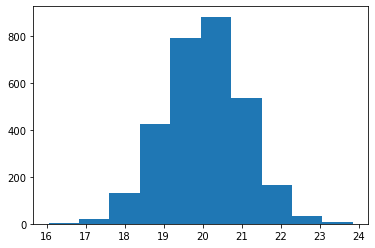

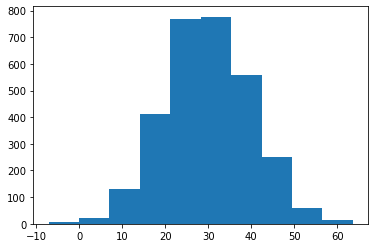

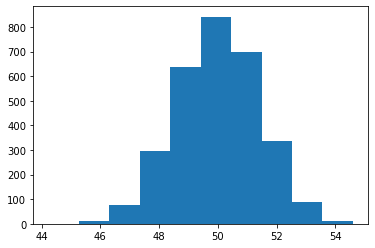

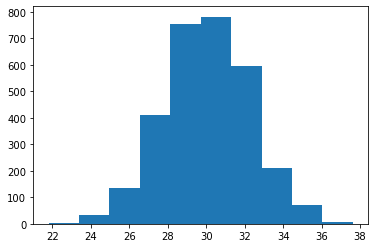

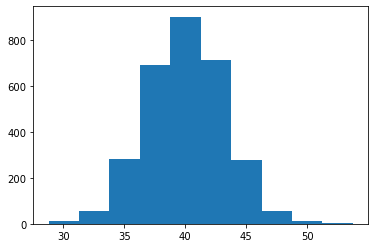

In [82]:
import matplotlib.pyplot as plt

plt.hist(testing_dataset[:,0])
plt.show()
plt.hist(testing_dataset[:,1])
plt.show()
plt.hist(testing_dataset[:,2])
plt.show()
plt.hist(testing_dataset[:,3])
plt.show()
plt.hist(testing_dataset[:,4])
plt.show()

In [ ]:
plt.hist(testing_dataset[:,0])
plt.show()
plt.hist(testing_dataset[:,1])
plt.show()
plt.hist(testing_dataset[:,2])
plt.show()
plt.hist(testing_dataset[:,3])
plt.show()
plt.hist(testing_dataset[:,4])
plt.show()

In [ ]:
# ignore bellow

In [77]:
class VAE2(nn.Module):
    def __init__(self, zdim, input_dim):
        super(VAE2, self).__init__()

        self.fc1 = nn.Linear(input_dim, 10)
        self.fc2 = nn.Linear(10, 20)
        self.fc21 = nn.Linear(20, zdim)
        self.fc22 = nn.Linear(20, zdim)
        self.fc3 = nn.Linear(zdim, 20)
        self.fc33 = nn.Linear(20, 10)
        self.fc4 = nn.Linear(10, input_dim)
        self.input_dim = input_dim
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        return self.fc21(h2), self.fc22(h2)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5*logvar)
            eps = torch.randn(mu.size(0),mu.size(1)) # assume eps normally distributed ~N(0,1)
#             eps = torch.randn_like(std)
            z = mu+ eps*std
#             return eps.mul(std).add_(mu)
            return z
#         else:
#             return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h33 = F.relu(self.fc33(h3))
        return self.fc4(h33)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, self.input_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [78]:
batch_size = 128

model = VAE2(5, 5)
train(model, num_epochs = 300, batch_size = batch_size, learning_rate = 0.05)

Epoch:1, Loss:20160.1191
Epoch:2, Loss:11152.3408
Epoch:3, Loss:14864.6934
Epoch:4, Loss:13749.9297
Epoch:5, Loss:12644.2627
Epoch:6, Loss:11069.0283
Epoch:7, Loss:11768.6602
Epoch:8, Loss:11521.3203
Epoch:9, Loss:13163.5000
Epoch:10, Loss:13343.1689
Epoch:11, Loss:12204.7314
Epoch:12, Loss:12114.1250
Epoch:13, Loss:8671.2715
Epoch:14, Loss:3585.7986
Epoch:15, Loss:3042.1360
Epoch:16, Loss:3022.2700
Epoch:17, Loss:3119.3416
Epoch:18, Loss:2627.7881
Epoch:19, Loss:3071.5305
Epoch:20, Loss:3084.0776
Epoch:21, Loss:2652.7573
Epoch:22, Loss:3277.7158
Epoch:23, Loss:2764.3704
Epoch:24, Loss:2493.7070
Epoch:25, Loss:3179.5950
Epoch:26, Loss:2743.1172
Epoch:27, Loss:2539.2222
Epoch:28, Loss:2620.8127
Epoch:29, Loss:2700.0112
Epoch:30, Loss:2758.3076
Epoch:31, Loss:2665.2764
Epoch:32, Loss:2694.6265
Epoch:33, Loss:2433.5249
Epoch:34, Loss:2442.6548
Epoch:35, Loss:2390.9570
Epoch:36, Loss:2875.3555
Epoch:37, Loss:2711.7163
Epoch:38, Loss:2899.5991
Epoch:39, Loss:2709.6169
Epoch:40, Loss:2495.16

In [ ]:
mean = [0, 0]
cov = [[1, 0], [0, 100]]  # diagonal covariance

In [ ]:
import matplotlib.pyplot as plt
x, y = np.random.multivariate_normal(mean, cov, 5000).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()